# Controllable Generation

### Goals
In this notebook, you're going to implement a GAN controllability method using gradients from a classifier. By training a classifier to recognize a relevant feature, you can use it to change the generator's inputs (z-vectors) to make it generate images with more or less of that feature.

You will be started you off with a pre-trained generator and classifier, so that you can focus on the controllability aspects. However, in case you would like to train your own classifier, the code for that has been provided as well.

### Learning Objectives
1. Observe how controllability can change a generator's output.
2. Resolve some of the challenges that entangled features pose to controllability.

## Getting started!

You will start off by importing useful libraries and packages and defining a visualization function. You have also been provided with the generator, noise, and classifier code from earlier assignments. The classifier has the same archicture as the earlier critic (remember that the discriminator/critic is simply a classifier used to classify real and fake).

#### CelebA
For this notebook, instead of the MNIST dataset, you will be using [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). CelebA is a dataset of annotated celebrity images. Since they are colored (not black-and-white), the images have three channels for red, green, and blue (RGB).

![celeba](celeba.png)

#### Packages and Visualization

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### Generator and Noise

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Classifier

In [3]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

## Specifying Parameters
Before you begin training, you need to specify a few parameters:
  *   z_dim: the dimension of the noise vector
  *   batch_size: the number of images per forward/backward pass
  *   device: the device type

In [4]:
z_dim = 64
batch_size = 128
device = 'mps'

## Train a Classifier (Optional)

You're welcome to train your own classifier with this code, but you are provided with a pretrained one later in the code. Feel free to skip this code block, and if you do want to train your own classifier, it is recommended that you initially go through the assignment with the provided classifier!

In [5]:
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # You can run this code to train your own classifier, but there is a provided pretrained one.
    # If you'd like to use this, just run "train_classifier(filename)"
    # to train and save a classifier on the label indices to that filename.

    # Target all the classes, so that's how many the classifier will learn
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Epoch {epoch}, step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Uncomment the last line to train your own classfier - this line will not work in Coursera.
# If you'd like to do this, you'll have to download it and run it, ideally using a GPU 
# train_classifier("filename")

## Loading the Pretrained Models
You will then load the pretrained generator and classifier using the following code. (If you trained your own classifier, you can load that one here instead.)

In [6]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

FileNotFoundError: [Errno 2] No such file or directory: 'pretrained_celeba.pth'

## Training
Now you can start implementing a method for controlling your GAN!

#### Update Noise
For training, you need to write the code to update the noise to produce more of your desired feature. You do this by performing stochastic gradient ascent. You use stochastic gradient ascent to find the local maxima, as opposed to stochastic gradient descent which finds the local minima. Gradient ascent is gradient descent over the negative of the value being optimized. Their formulas are essentially the same, however, instead of subtracting the weighted value, stochastic gradient ascent adds it; it can be calculated by `new = old + (∇ old * weight)`, where ∇ is the gradient of `old`. You perform stochastic gradient ascent to try and maximize the amount of the feature you want. If you wanted to reduce the amount of the feature, you would perform gradient descent. However, in this assignment you are interested in maximize your feature using gradient ascent, since many features in the dataset are not present much more often than they're present and you are trying to add a feature to the images, not remove.

Given the noise with its gradient already calculated through the classifier, you want to return the new noise vector.

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">calculate_updated_noise</font></code></b>
</font>
</summary>

1.   Remember the equation for gradient ascent: `new = old + (∇ old * weight)`.

</details>

In [21]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: calculate_updated_noise
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''
    #### START CODE HERE ####
    new_noise = noise + weight*(noise.grad)
    #### END CODE HERE ####
    return new_noise

In [22]:
# UNIT TEST
# Check that the basic function works
opt.zero_grad()
noise = torch.ones(20, 20) * 2
noise.requires_grad_()
fake_classes = (noise ** 2).mean()
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1)
assert type(new_noise) == torch.Tensor
assert tuple(new_noise.shape) == (20, 20)
assert new_noise.max() == 2.0010
assert new_noise.min() == 2.0010
assert torch.isclose(new_noise.sum(), torch.tensor(0.4) + 20 * 20 * 2)
print("Success!")

Success!


In [23]:
# Check that it works for generated images
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_()
fake = gen(noise)
fake_classes = classifier(fake)[:, 0]
fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]
assert torch.all(fake_classes_new > fake_classes)
print("Success!")

Success!


#### Generation
Now, you can use the classifier along with stochastic gradient ascent to make noise that generates more of a certain feature. In the code given to you here, you can generate smiling faces. Feel free to change the target index and control some of the other features in the list! You will notice that some features are easier to detect and control than others.

The list you have here are the features labeled in CelebA, which you used to train your classifier. If you wanted to control another feature, you would need to get data that is labeled with that feature and train a classifier on that feature.

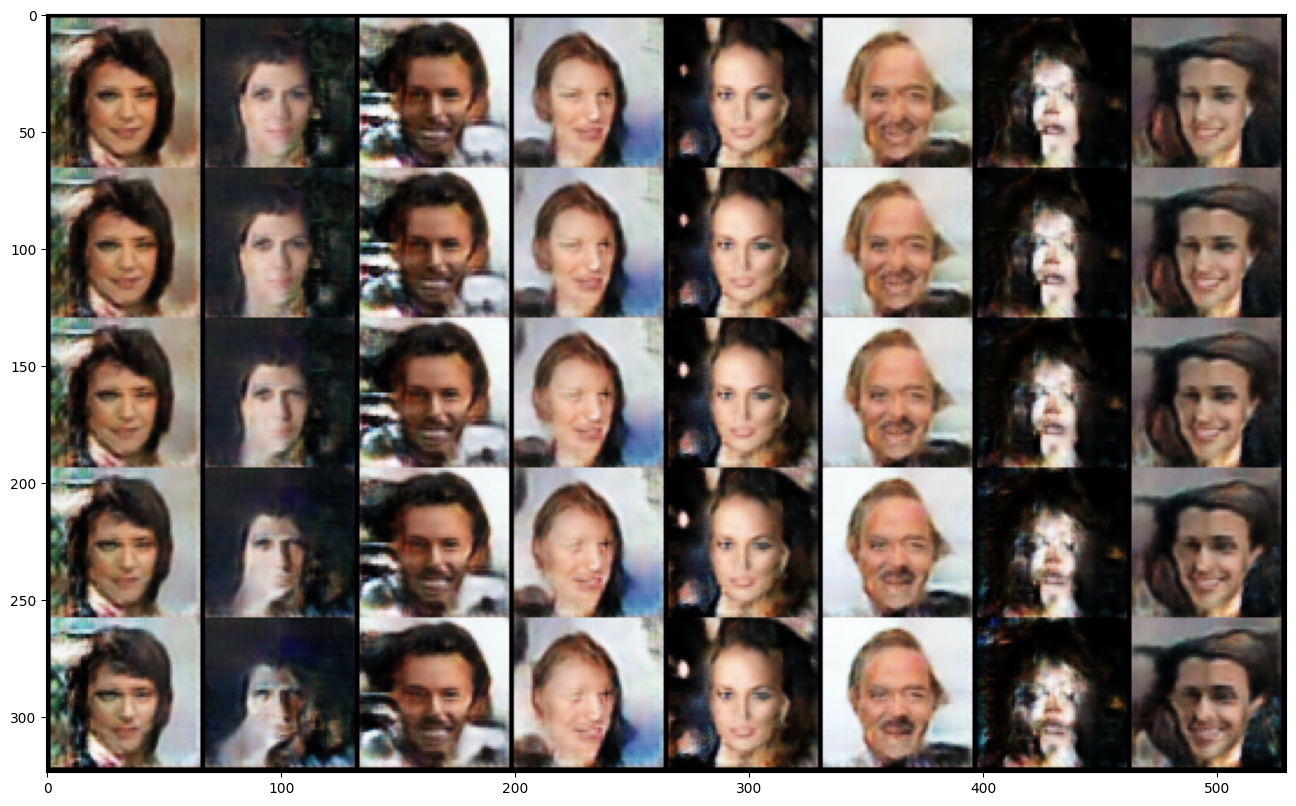

In [24]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Mustache") # Feel free to change this value to any string from feature_names!

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

## Entanglement and Regularization
You may also notice that sometimes more features than just the target feature change. This is because some features are entangled. To fix this, you can try to isolate the target feature more by holding the classes outside of the target class constant. One way you can implement this is by penalizing the differences from the original class with L2 regularization. This L2 regularization would apply a penalty for this difference using the L2 norm and this would just be an additional term on the loss function.

Here, you'll have to implement the score function: the higher, the better. The score is calculated by adding the target score and a penalty -- note that the penalty is meant to lower the score, so it should have a negative value.

For every non-target class, take the difference between the current noise and the old noise. The greater this value is, the more features outside the target have changed. You will calculate the magnitude of the change, take the mean, and negate it. Finally, add this penalty to the target score. The target score is the mean of the target class in the current noise.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">get_score</font></code></b>
</font>
</summary>

1.   The higher the score, the better!
2.   You want to calculate the loss per image, so you'll need to pass a dim argument to [`torch.norm`](https://pytorch.org/docs/stable/generated/torch.norm.html).
3.   Calculating the magnitude of the change requires you to take the norm of the difference between the classifications, not the difference of the norms.

</details>

In [25]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_score
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class
        other_indices: the indices of the other classes
        penalty_weight: the amount that the penalty should be weighted in the overall score
    '''
    # Steps: 1) Calculate the change between the original and current classifications (as a tensor)
    #           by indexing into the other_indices you're trying to preserve, like in x[:, features].
    #        2) Calculate the norm (magnitude) of changes per example.
    #        3) Multiply the mean of the example norms by the penalty weight. 
    #           This will be your other_class_penalty.
    #           Make sure to negate the value since it's a penalty!
    #        4) Take the mean of the current classifications for the target feature over all the examples.
    #           This mean will be your target_score.
    #### START CODE HERE ####
    # Calculate the error on other_indices    
    other_distances = (original_classifications-current_classifications)[:,other_indices]
    # Calculate the norm (magnitude) of changes per example and multiply by penalty weight  
    other_class_penalty = -torch.mean(torch.norm(other_distances, dim=1))*penalty_weight
    # Take the mean of the current classifications for the target feature  
    target_score = torch.mean(current_classifications[:,target_indices])
    #### END CODE HERE ####
    return target_score + other_class_penalty

In [26]:
# UNIT TEST
assert torch.isclose(
    get_score(torch.ones(4, 3), torch.zeros(4, 3), [0], [1, 2], 0.2), 
    1 - torch.sqrt(torch.tensor(2.)) * 0.2
)
rows = 10
current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()

# Must be 3
assert get_score(current_class, original_class, [1, 3] , [0, 2], 0.2).item() == 3

current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[4] * rows, [4] * rows, [2] * rows, [1] * rows]).T.float()

# Must be 3 - 0.2 * sqrt(10)
assert torch.isclose(get_score(current_class, original_class, [1, 3] , [0, 2], 0.2), 
                     -torch.sqrt(torch.tensor(10.0)) * 0.2 + 3)

print("Success!")

Success!


In the following block of code, you will run the gradient ascent with this new score function. You might notice a few things after running it: 

1.   It may fail more often at producing the target feature when compared to the original approach. This suggests that the model may not be able to generate an image that has the target feature without changing the other features. This makes sense! For example, it may not be able to generate a face that's smiling but whose mouth is NOT slightly open. This may also expose a limitation of the generator. 
Alternatively, even if the generator can produce an image with the intended features, it might require many intermediate changes to get there and may get stuck in a local minimum.

2.   This process may change features which the classifier was not trained to recognize since there is no way to penalize them with this method. Whether it's possible to train models to avoid changing unsupervised features is an open question.

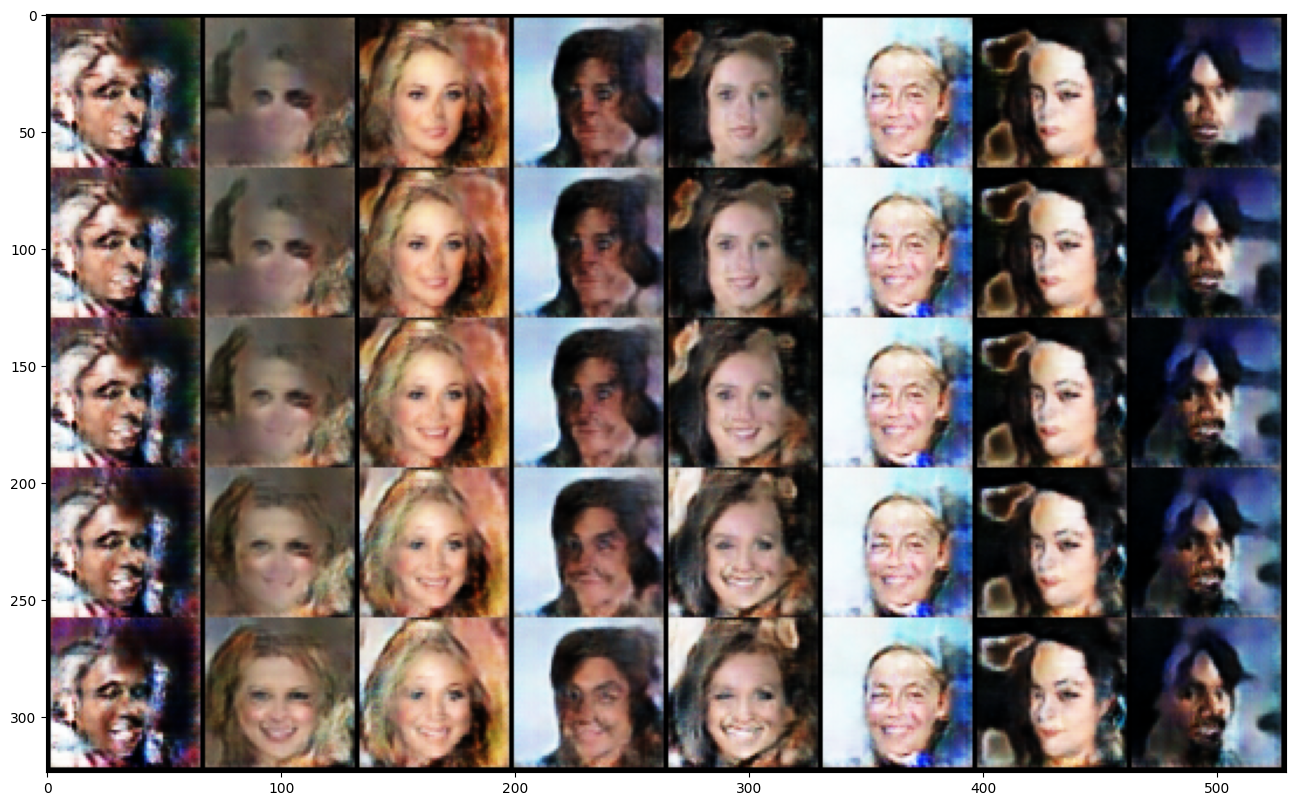

In [27]:
fake_image_history = []
### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)